### PART 2

#### Interesting to test and compare 3 to 4 different non linear models (maybe testing more but only 3 to 4 in the report), try to not have 3 models of the same 'family' 

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance 
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV

In [2]:
# Data paths
labeled_data_path = '../data/data_labeled/'
unlabeled_data_path = '../data/data_unlabeled/'

# Image paths
img_test_unlabeled_path = '../data/data_labeled/Img_test/'
img_train_unlabeled_path = '../data/data_labeled/Img_train/'
X_img_path = '../data/data_unlabeled/Img/'

# Load csv's
X_test = pd.read_csv(labeled_data_path + 'X_test.csv')
X_train = pd.read_csv(labeled_data_path + 'X_train.csv')
y_test = pd.read_csv(labeled_data_path + 'y_test.csv', header=None)
y_train = pd.read_csv(labeled_data_path + 'y_train.csv', header=None)
X_unlabeled = pd.read_csv(unlabeled_data_path + 'X.csv')

X_test.head()

,age,blood pressure,calcium,cholesterol,hemoglobin,height,potassium,profession,sarsaparilla,smurfberry liquor,smurfin donuts,vitamin D,weight,img_filename
0,85,106.92,2.25,120.85,14.90,7.41,3.26,resource extraction,Low,High,Moderate,36.27,93.20,heart_0.png
1,130,94.73,2.61,121.74,16.88,7.53,4.74,manufacturing,Very high,Very high,Moderate,25.97,105.24,heart_6.png
2,180,110.31,2.47,75.35,15.52,8.02,4.29,manufacturing,High,Moderate,Very low,37.53,100.61,heart_7.png
3,78,95.46,2.28,125.30,11.68,7.75,4.17,services,Very low,Low,Moderate,28.19,103.94,heart_10.png
4,116,106.13,2.11,89.98,14.83,7.89,4.73,resource extraction,Low,Very high,Low,30.07,82.53,heart_11.png


In [3]:

#Save data before cleaning
X_train_clean = X_train.copy()
X_test_clean = X_test.copy()
X_unlabeled_clean = X_unlabeled.copy()

X_train = X_train.drop(columns=['img_filename'])
X_test = X_test.drop(columns=['img_filename'])
X_unlabeled = X_unlabeled.drop(columns=['img_filename'])

X_train = pd.get_dummies(X_train, columns=['profession'])
X_test = pd.get_dummies(X_test, columns=['profession'])
X_unlabeled = pd.get_dummies(X_unlabeled, columns=['profession'])

# Ordinal encoding of consumption features
consumption_map = {
    'Very low': 1,
    'Low': 2,
    'Moderate': 3,
    'High': 4,
    'Very high': 5
}

for col in ['sarsaparilla', 'smurfberry liquor', 'smurfin donuts']:
    X_train[col] = X_train[col].map(consumption_map)
    X_test[col] = X_test[col].map(consumption_map)
    X_unlabeled[col] = X_unlabeled[col].map(consumption_map)

# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print("Train subset:", X_train.shape)
print("Validation set:", X_val.shape)


# Standardize numerical features
numerical_features = [
    'age', 'blood pressure', 'calcium', 'cholesterol',
    'hemoglobin', 'height', 'potassium',
    'vitamin D', 'weight'
]

X_train_original = X_train.copy()
X_val_original = X_val.copy()
X_test_original = X_test.copy()
X_unlabeled_original = X_unlabeled.copy()

scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_val[numerical_features] = scaler.transform(X_val[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])
X_unlabeled[numerical_features] = scaler.transform(X_unlabeled[numerical_features])
X_test.head()


Train subset: (800, 18)
Validation set: (200, 18)


,age,blood pressure,calcium,cholesterol,hemoglobin,height,potassium,sarsaparilla,smurfberry liquor,smurfin donuts,vitamin D,weight,profession_administration and governance,profession_craftsmanship,profession_food production,profession_manufacturing,profession_resource extraction,profession_services
0,-1.088731,-0.153842,-0.965800,0.382095,0.328558,-0.463442,-2.107149,2,4,3,1.202304,-0.726562,False,False,False,False,True,False
1,0.404898,-1.246817,0.777981,0.422910,1.290066,-0.161914,0.864484,5,5,3,-0.849324,-0.021621,False,False,False,True,False,False
2,2.064486,0.150110,0.099844,-1.704512,0.629636,1.069325,-0.039053,4,3,1,1.453280,-0.292707,False,False,False,True,False,False
3,-1.321073,-1.181364,-0.820485,0.586170,-1.235107,0.390887,-0.279996,1,2,3,-0.407129,-0.097736,False,False,False,False,False,True
4,-0.059787,-0.224675,-1.643937,-1.033588,0.294565,0.742670,0.844406,2,5,2,-0.032657,-1.351289,False,False,False,False,True,False


Utils

In [4]:

def compute_rmse(y_pred, y_true):

    y_pred, y_true = np.asarray(y_pred), np.asarray(y_true)
    mse = np.mean((y_pred - y_true) ** 2)
    return np.sqrt(mse)

def optimize_model(model, params, X_train, y_train, scoring_metric='neg_root_mean_squared_error'):
    """
    Optimise les hyperparamètres du modèle en utilisant GridSearchCV.
    """
    # GridSearchCV utilise la validation croisée (CV) pour trouver la meilleure combinaison de paramètres
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring=scoring_metric,
        cv=5, # 5-fold cross-validation
        n_jobs=-1,
        verbose=1
    )
    
    # Entraînement et optimisation
    grid_search.fit(X_train, y_train)
    
    # Affichage des meilleurs résultats
    best_score = -grid_search.best_score_ # Le score est négatif car nous maximisons un score d'erreur
    print(f"Meilleurs paramètres trouvés: {grid_search.best_params_}")
    print(f"RMSE de Cross-Validation (Moyenne): {best_score:.4f}")
    
    return grid_search.best_estimator_, best_score



Feature Selection

In [5]:
mi_scores = mutual_info_regression(X_train, y_train.values.ravel(), random_state=42)
mi_df = pd.DataFrame({'Feature': X_train.columns, 'MI': mi_scores})
mi_df = mi_df.sort_values(by='MI', ascending=False).reset_index(drop=True)


mean_mi, std_mi = mi_df['MI'].mean(), mi_df['MI'].std()

threshold_soft = mean_mi + 0.25 * std_mi
selected_by_threshold = mi_df[mi_df['MI'] > threshold_soft]['Feature'].tolist()

# En cas de peu de sélection, garde toutes les features avec MI > 0
if len(selected_by_threshold) < 6:
    selected_by_threshold = mi_df[mi_df['MI'] > 0]['Feature'].tolist()

print(f"\n Seuil souple = {threshold_soft:.4f}")
print(f"{len(selected_by_threshold)} features retenues après filtrage MI :")
print(selected_by_threshold)

# Sous-ensembles correspondants
selected_features_mi = selected_by_threshold
X_train_mi = X_train[selected_features_mi].copy()
X_val_mi   = X_val[selected_features_mi].copy()
X_test_mi  = X_test[selected_features_mi].copy()
X_unlabeled_mi = X_unlabeled[selected_features_mi].copy()


 Seuil souple = 0.0676
17 features retenues après filtrage MI :
['blood pressure', 'cholesterol', 'potassium', 'weight', 'smurfin donuts', 'sarsaparilla', 'profession_resource extraction', 'age', 'profession_administration and governance', 'hemoglobin', 'profession_craftsmanship', 'vitamin D', 'height', 'calcium', 'profession_manufacturing', 'profession_services', 'smurfberry liquor']


MRmR

In [6]:
corr_matrix = X_train_mi.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [col for col in upper.columns if any(upper[col] > 0.85)]
X_train_mrmr = X_train_mi.drop(columns=high_corr, errors='ignore')
X_val_mrmr = X_val_mi.drop(columns=high_corr, errors='ignore')
X_test_mrmr = X_test_mi.drop(columns=high_corr, errors='ignore')
X_unlabeled_mrmr = X_unlabeled_mi.drop(columns=high_corr, errors='ignore')
print(f"\n{len(high_corr)} variables redondantes supprimées après mRMR simplifié :")
print(high_corr)
print(f"{X_train_mrmr.shape[1]} features restantes après mRMR.")


0 variables redondantes supprimées après mRMR simplifié :
[]
17 features restantes après mRMR.


RF selection

In [33]:
X_train_full = pd.concat([X_train_mrmr, X_val_mrmr], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)
y_train_ravel = y_train_full.values.ravel()

rf_selector = RandomForestRegressor(n_estimators=100, random_state =42, n_jobs=-1)
rf_selector.fit(X_train_full, y_train_ravel)

importances = rf_selector.feature_importances_
feature_names = X_train_full.columns
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 15 des caractéristiques selon Random Forest Importance:")
print(feature_importances_df.head(15))


Top 15 des caractéristiques selon Random Forest Importance:
                                     Feature  Importance
0                             blood pressure    0.577273
9                                 hemoglobin    0.109448
2                                  potassium    0.091355
7                                        age    0.040188
3                                     weight    0.038874
1                                cholesterol    0.031057
12                                    height    0.025507
11                                 vitamin D    0.022803
13                                   calcium    0.017964
5                               sarsaparilla    0.016024
4                             smurfin donuts    0.010776
16                         smurfberry liquor    0.007210
6             profession_resource extraction    0.003231
8   profession_administration and governance    0.003183
15                       profession_services    0.002142


Sélection de N pour le RF selector

In [ ]:
rmse_scorer_for_rfecv = make_scorer(compute_rmse, greater_is_better=False)
rf_estimator = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
print("Début de la sélection de caractéristiques RFECV (Cross-Validation) en utilisant la RMSE...")
rfecv_selector = RFECV(
    estimator=rf_estimator,
    step=1,
    cv=5,                             # Utilise 5 plis de Cross-Validation
    scoring=rmse_scorer_for_rfecv,    # Utilisation de votre RMSE scorer
    n_jobs=-1,
    verbose=1
)
rfecv_selector.fit(X_train_full, y_train_ravel)

N_optimal = rfecv_selector.n_features_
print(f"\nNombre optimal de caractéristiques (N) déterminé par CV : {N_optimal}")
selected_features_rfecv = X_train_full.columns[rfecv_selector.support_].tolist()
print("\nCaractéristiques sélectionnées :")
print(selected_features_rfecv)

#X_train_part2 = X_train_full[selected_features_rfecv].copy()
#X_test_part2 = X_test_mrmr[selected_features_rfecv].copy()

Début de la sélection de caractéristiques RFECV (Cross-Validation) en utilisant la RMSE...
Fitting estimator with 17 features.


c:\Users\User\Desktop\GBIOM2\LELEC2870_Machine_learning\LELEC2870-Project\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting estimator with 16 features.


c:\Users\User\Desktop\GBIOM2\LELEC2870_Machine_learning\LELEC2870-Project\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting estimator with 15 features.


c:\Users\User\Desktop\GBIOM2\LELEC2870_Machine_learning\LELEC2870-Project\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting estimator with 14 features.


c:\Users\User\Desktop\GBIOM2\LELEC2870_Machine_learning\LELEC2870-Project\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting estimator with 13 features.


c:\Users\User\Desktop\GBIOM2\LELEC2870_Machine_learning\LELEC2870-Project\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting estimator with 12 features.


c:\Users\User\Desktop\GBIOM2\LELEC2870_Machine_learning\LELEC2870-Project\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting estimator with 11 features.


c:\Users\User\Desktop\GBIOM2\LELEC2870_Machine_learning\LELEC2870-Project\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting estimator with 10 features.


c:\Users\User\Desktop\GBIOM2\LELEC2870_Machine_learning\LELEC2870-Project\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting estimator with 9 features.


c:\Users\User\Desktop\GBIOM2\LELEC2870_Machine_learning\LELEC2870-Project\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting estimator with 8 features.


c:\Users\User\Desktop\GBIOM2\LELEC2870_Machine_learning\LELEC2870-Project\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting estimator with 7 features.


c:\Users\User\Desktop\GBIOM2\LELEC2870_Machine_learning\LELEC2870-Project\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting estimator with 6 features.


c:\Users\User\Desktop\GBIOM2\LELEC2870_Machine_learning\LELEC2870-Project\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting estimator with 5 features.


c:\Users\User\Desktop\GBIOM2\LELEC2870_Machine_learning\LELEC2870-Project\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting estimator with 4 features.


c:\Users\User\Desktop\GBIOM2\LELEC2870_Machine_learning\LELEC2870-Project\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting estimator with 3 features.


c:\Users\User\Desktop\GBIOM2\LELEC2870_Machine_learning\LELEC2870-Project\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\User\Desktop\GBIOM2\LELEC2870_Machine_learning\LELEC2870-Project\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\User\Desktop\GBIOM2\LELEC2870_Machine_learning\LELEC2870-Project\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Nombre optimal de caractéristiques (N) déterminé par CV : 2

Caractéristiques sélectionnées :
['blood pressure', 'hemoglobin']


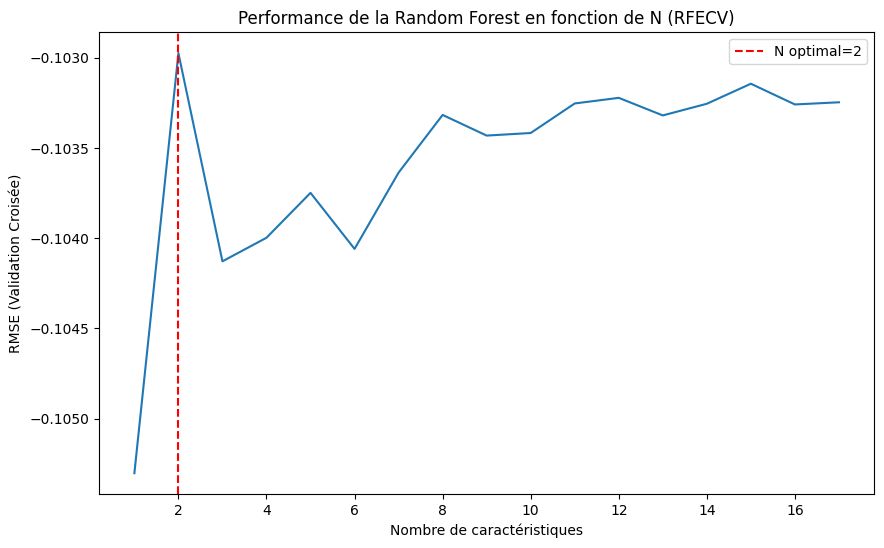

In [ ]:
# Affichage de la performance en fonction du nombre de caractéristiques
scores_rmse = -rfecv_selector.cv_results_['mean_test_score'] # Non, pas de négatif ici!

# Assuming it returns the actual RMSE values (since greater_is_better=False)
scores_rmse = rfecv_selector.cv_results_['mean_test_score'] 
n_features_range = range(1, len(X_train_full.columns) + 1)

# Création du graphique (nécessite matplotlib)
plt.figure(figsize=(10, 6))
plt.plot(n_features_range, scores_rmse)
plt.xlabel("Nombre de caractéristiques")
plt.ylabel("RMSE (Validation Croisée)")
plt.title("Performance de la Random Forest en fonction de N (RFECV)")
plt.axvline(x=N_optimal, color='r', linestyle='--', label=f'N optimal={N_optimal}')
plt.legend()
plt.show()

RMSE minimale trouvée : 0.1030 (à N=2)
RMSE tolérée (min + 0.2%) : 0.1032
Nombre optimal de caractéristiques (N) pour la robustesse : 15

Caractéristiques sélectionnées pour la Partie 2 (méthode robuste) :
Nombre total: 15
['blood pressure', 'hemoglobin', 'potassium', 'age', 'weight', 'cholesterol', 'height', 'vitamin D', 'calcium', 'sarsaparilla', 'smurfin donuts', 'smurfberry liquor', 'profession_resource extraction', 'profession_administration and governance', 'profession_services']


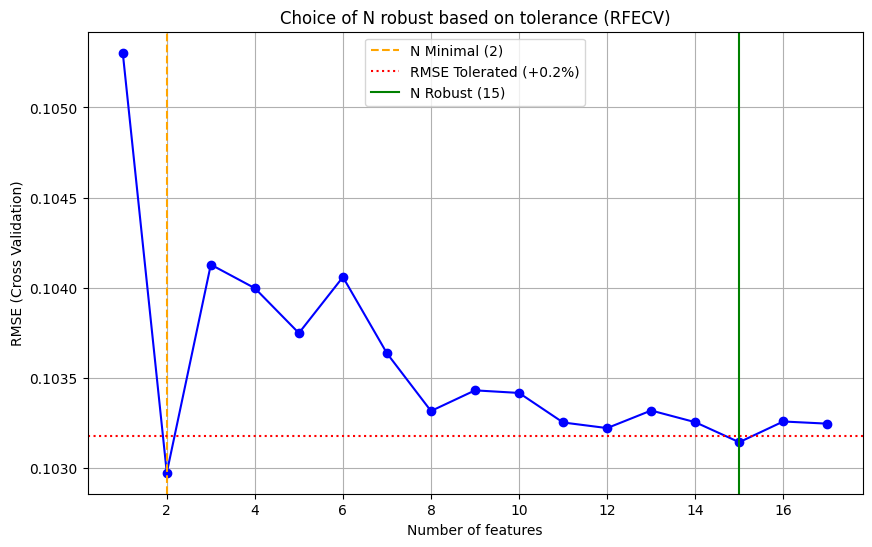

In [29]:
raw_scores = rfecv_selector.cv_results_['mean_test_score']
rmse_scores = -raw_scores
n_features_range = range(1, len(X_train_full.columns) + 1)

# 2. Détermination de la RMSE minimale et du N minimal
rmse_min = np.min(rmse_scores)
n_min = np.argmin(rmse_scores) + 1  # +1 car l'index commence à 0

# 3. Définition de la Tolérance (méthode du plateau)
# Tolérance : On accepte une RMSE jusqu'à 1% plus élevée que la RMSE minimale
# C'est un choix justifié par la recherche de robustesse, mais vous pouvez ajuster (ex: 0.5% ou 2%)
TOLERANCE_PCT = 0.002
rmse_toleree = rmse_min * (1 + TOLERANCE_PCT)

n_optimal_robuste = n_min
for i, rmse in enumerate(rmse_scores):
    n_features = i + 1
    if rmse <= rmse_toleree:
        # On choisit le N le plus grand (dernière valeur qui respecte la tolérance)
        n_optimal_robuste = n_features 

print(f"RMSE minimale trouvée : {rmse_min:.4f} (à N={n_min})")
print(f"RMSE tolérée (min + {TOLERANCE_PCT*100}%) : {rmse_toleree:.4f}")
print(f"Nombre optimal de caractéristiques (N) pour la robustesse : {n_optimal_robuste}")

#importances2 = rfecv_selector.estimator_.feature_importances_
#feature_names2 = X_train_full.columns

feature_importances_df2 = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

selected_features_names_robuste = feature_importances_df2['Feature'].head(n_optimal_robuste).tolist()

print("\nCaractéristiques sélectionnées pour la Partie 2 (méthode robuste) :")
print(f"Nombre total: {len(selected_features_names_robuste)}")
print(selected_features_names_robuste)

# 6. Application de la sélection aux ensembles d'entraînement et de test
X_train_part2 = X_train_full[selected_features_names_robuste].copy()
X_test_part2 = X_test_mrmr[selected_features_names_robuste].copy()

# Affiche le graphique pour la justification (nécessite matplotlib)
plt.figure(figsize=(10, 6))
plt.plot(n_features_range, rmse_scores, marker='o', linestyle='-', color='blue')
plt.axvline(x=n_min, color='orange', linestyle='--', label=f'N Minimal ({n_min})')
plt.axhline(y=rmse_toleree, color='red', linestyle=':', label=f'RMSE Tolerated (+{TOLERANCE_PCT*100}%)')
plt.axvline(x=n_optimal_robuste, color='green', linestyle='-', label=f'N Robust ({n_optimal_robuste})')
plt.xlabel("Number of features")
plt.ylabel("RMSE (Cross Validation)")
plt.title("Choice of N robust based on tolerance (RFECV)")
plt.legend()
plt.grid(True)
plt.savefig("C:/Users/User/Desktop/GBIOM2/LELEC2870_Machine_learning/LELEC2870-Project/plots/choice_of_N.pdf")
plt.show()

Parameters optimization

In [31]:
print("\n--- Optimisation du Random Forest ---")

# Réutiliser le scorer RMSE négatif pour la maximisation
# Assurez-vous que y_train_full et X_train_part2 sont définis avec N=15
# y_train_full = pd.concat([y_train, y_val], axis=0)
# X_train_part2 = X_train_full[selected_features_names_final].copy()

# Si rmse_scorer_for_rfecv n'est pas déjà défini dans ce bloc :
# def compute_rmse(y_pred, y_true):
#     y_pred, y_true = np.asarray(y_pred), np.asarray(y_true)
#     mse = np.mean((y_pred - y_true) ** 2)
#     return np.sqrt(mse)
# rmse_scorer_for_rfecv = make_scorer(compute_rmse, greater_is_better=False)
y_train_ravel = y_train_full.values.ravel()

param_grid_rf = {
    # Nombre d'arbres : doit être suffisamment grand pour la stabilité
    'n_estimators': [100, 300, 500], 
    
    # Profondeur maximale : contrôle la complexité et l'overfitting
    'max_depth': [10, 20, None], # None signifie illimité
    
    # Nombre de features à considérer à chaque split
    # 'sqrt' est souvent la meilleure valeur par défaut pour la régression
    'max_features': ['sqrt', 0.5, 0.7] 
    
    # 'min_samples_split' : [2, 5] peut être ajouté si le tuning est trop rapide
}

rf_estimator = RandomForestRegressor(random_state=42, n_jobs=-1)

rf_grid = GridSearchCV(
    estimator=rf_estimator,
    param_grid=param_grid_rf,
    scoring=rmse_scorer_for_rfecv,
    cv=5,
    n_jobs=-1,
    verbose=2
)
# Entraînement et tuning sur les 15 caractéristiques
rf_grid.fit(X_train_part2, y_train_ravel)

# Extraction du résultat RMSE réel (inversion du signe)
best_rmse_val_rf = -rf_grid.best_score_ 

print(f"\nMeilleur RMSE (Validation Croisée RF) : {best_rmse_val_rf:.4f}")
print(f"Meilleurs hyperparamètres RF : {rf_grid.best_params_}")

# Sauvegarder le meilleur modèle pour la comparaison finale
best_rf_model = rf_grid.best_estimator_


--- Optimisation du Random Forest ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Meilleur RMSE (Validation Croisée RF) : 0.0436
Meilleurs hyperparamètres RF : {'max_depth': None, 'max_features': 0.7, 'n_estimators': 300}


In [ ]:
print("\n--- Optimisation du K-NN ---")

# Assurez-vous que rmse_scorer_for_rfecv, X_train_part2, et y_train_full sont définis

param_grid_knn = {
    # Nombre de voisins (k) : une valeur impaire est préférable
    'n_neighbors': [3, 5, 7, 9, 11, 15], 
    
    # Poids : Uniforme ou Distance (les plus proches comptent plus)
    'weights': ['uniform', 'distance'], 
    
    # Métrica de distance (p=1: Manhattan, p=2: Euclidienne)
    'p': [1, 2] 
}

knn_estimator = KNeighborsRegressor(n_jobs=-1)

knn_grid = GridSearchCV(
    estimator=knn_estimator,
    param_grid=param_grid_knn,
    scoring=rmse_scorer_for_rfecv,
    cv=5,
    n_jobs=-1,
    verbose=2
)

print("\n--- Optimisation du k-Nearest Neighbors (kNN) ---")
print("Début du tuning kNN...")

# Entraînement et tuning sur les 15 caractéristiques
knn_grid.fit(X_train_part2, y_train_ravel)

# Extraction du résultat RMSE réel (inversion du signe)
best_rmse_val_knn = -knn_grid.best_score_ 

print(f"\nMeilleur RMSE (Validation Croisée kNN) : {best_rmse_val_knn:.4f}")
print(f"Meilleurs hyperparamètres kNN : {knn_grid.best_params_}")

# Sauvegarder le meilleur modèle pour la comparaison finale
best_knn_model = knn_grid.best_estimator_

In [ ]:
print("\n--- Optimisation du SVR ---")
# Définir la grille d'hyperparamètres (large pour commencer, puis affiner)
param_grid_svr = {
    'kernel': ['rbf'], 
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1]
}
param_grid_svr_test = [
    {'kernel': ['rbf'], 'C': [0.1, 1, 10], 'gamma': [0.001, 0.01]}, # Affinez autour du résultat précédent
    {'kernel': ['linear'], 'C': [0.1, 1, 10, 100]} # Testez le noyau linéaire
]
param_grid_svr_linear = {
    'kernel': ['linear'], 
    'C': [0.1, 1, 10, 100, 1000] # Tester un C très élevé
}

# Définir GridSearchCV avec votre scorer RMSE
svr_grid = GridSearchCV(
    estimator=SVR(), 
    param_grid=param_grid_svr, 
    scoring=rmse_scorer_for_rfecv, # Utilisation du même scorer RMSE
    cv=5, 
    n_jobs=-1,
    verbose=1
)

print("\nDébut du tuning SVR...")
# Entraînement et tuning sur les 15 caractéristiques
svr_grid.fit(X_train_part2, y_train_full)

best_rmse_val = -svr_grid.best_score_ # Inverser le signe pour avoir le RMSE positif

print(f"Meilleur RMSE (Validation Croisée SVR) : {best_rmse_val:.4f}")
print(f"Meilleurs hyperparamètres SVR : {svr_grid.best_params_}")


--- Optimisation du SVR ---

Début du tuning SVR...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Meilleur RMSE (Validation Croisée SVR) : 0.1019
Meilleurs hyperparamètres SVR : {'C': 0.1, 'kernel': 'linear'}


c:\Users\User\Desktop\GBIOM2\LELEC2870_Machine_learning\LELEC2870-Project\.venv\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print("\n--- Optimisation du MLP (Simple) ---")


In [ ]:
# Rassembler les résultats des meilleurs modèles
results = {
    "Random Forest": {'model': best_rf_model, 'rmse': rmse_test_rf},
    "K-NN": {'model': best_knn_model, 'rmse': rmse_test_knn},
    "SVR": {'model': best_svr_model, 'rmse': rmse_test_svr},
    "MLP": {'model': best_mlp_model, 'rmse': rmse_test_mlp},
}

# Trouver le meilleur modèle
best_model_name = min(results, key=lambda k: results[k]['rmse'])
best_model = results[best_model_name]['model']

print(f"\n=======================================================")
print(f"Le meilleur modèle non linéaire global est: {best_model_name} avec RMSE = {results[best_model_name]['rmse']:.4f}")
print(f"=======================================================")

# --- ANALYSE D'IMPORTANCE PAR PERMUTATION ---
# Appliquée au meilleur modèle global
print(f"\n--- Importance par Permutation pour le meilleur modèle: {best_model_name} ---")

result = permutation_importance(
    best_model, 
    X_test_scaled_df, 
    y_test, 
    n_repeats=30, # Augmenter les répétitions pour plus de stabilité
    random_state=42, 
    n_jobs=-1
)

# Créer un DataFrame pour la visualisation
sorted_idx = result.importances_mean.argsort()[::-1]
feature_importance_df = pd.DataFrame({
    'Feature': X_test_scaled_df.columns[sorted_idx],
    'Importance_Mean': result.importances_mean[sorted_idx],
    'Importance_Std': result.importances_std[sorted_idx]
})

print(feature_importance_df)

#